In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import os
os.chdir('/content/drive/MyDrive/Graph_Neural_Network')

In [ ]:
!pip install torch_geometric==2.5.0
!pip install shap
import torch_geometric
from torch_geometric.data import Data, DataLoader
import numpy as np
import torch
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.model_selection import train_test_split
import torch.nn.functional as F
import networkx as nx
import seaborn as sns
import os

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 64.2/64.2 kB 2.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 25.7 MB/s eta 0:00:00


In [ ]:
df_classes = pd.read_csv('./data/elliptic_bitcoin_dataset/elliptic_txs_classes.csv')
df_edges = pd.read_csv('./data/elliptic_bitcoin_dataset/elliptic_txs_edgelist.csv')
df_features = pd.read_csv('./data/elliptic_bitcoin_dataset/elliptic_txs_features.csv', header=None)

In [ ]:
# 删除 unknown 类别，仅保留合法/非法交易（1/2）
df_classes = df_classes[df_classes['class'] != 'unknown']
df_classes['class'] = df_classes['class'].map({'1': 1, '2': 0})  # 1: illicit, 0: licit

/tmp/ipython-input-5-1951224802.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_classes['class'] = df_classes['class'].map({'1': 1, '2': 0})  # 1: illicit, 0: licit


In [ ]:
# 合并特征与类别标签
df_merge = df_features.merge(df_classes, how='inner', right_on="txId", left_on=0)
df_merge = df_merge.drop(['txId'], axis=1)

In [ ]:
# ====================== 图构建 ======================
nodes = df_merge[0].values
map_id = {j: i for i, j in enumerate(nodes)}

edges = df_edges[df_edges.txId1.isin(map_id) & df_edges.txId2.isin(map_id)].copy()
edges.txId1 = edges.txId1.map(map_id)
edges.txId2 = edges.txId2.map(map_id)
edges = edges.astype(int)
edge_index = np.array(edges.values).T
edge_index = torch.tensor(edge_index, dtype=torch.long).contiguous()
weights = torch.tensor([1] * edge_index.shape[1], dtype=torch.float32)

labels = torch.tensor(df_merge['class'].values, dtype=torch.float32)
node_features = torch.tensor(np.array(df_merge.drop([0, 'class', 1], axis=1).values), dtype=torch.float32)

elliptic_dataset = Data(x=node_features, edge_index=edge_index, edge_weights=weights, y=labels)

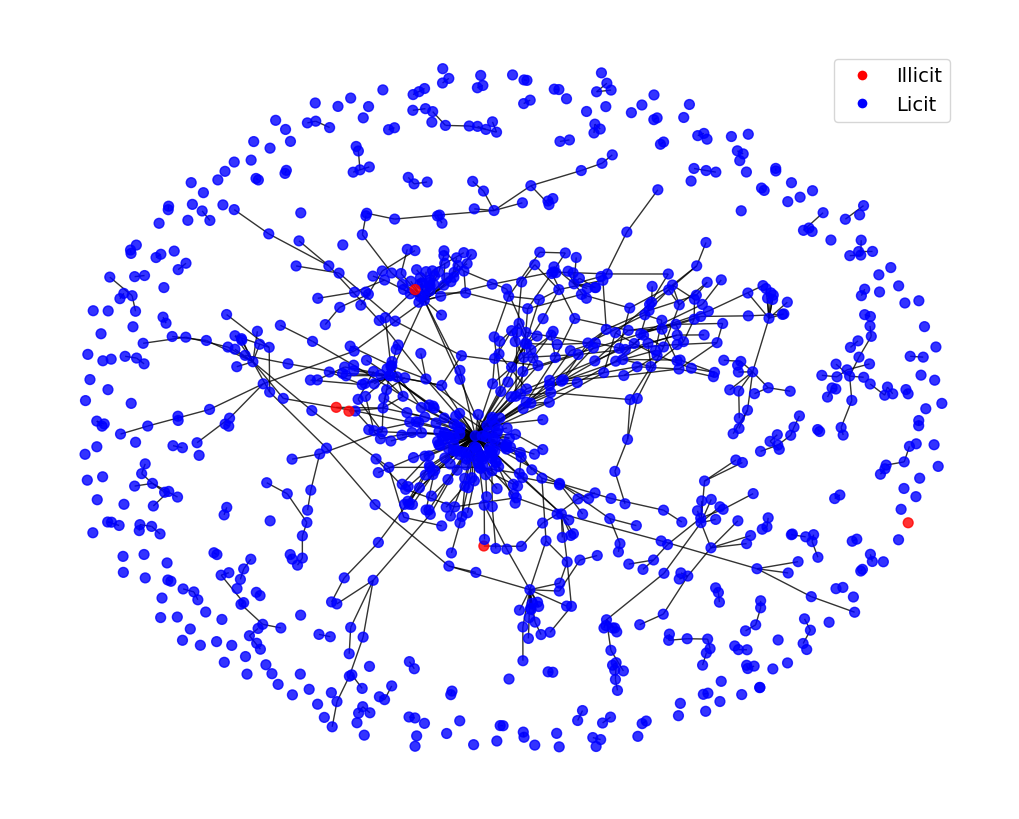

In [ ]:
# 由于 Elliptic Dataset 节点太多（约5万个），只选取子图（前1000个节点）进行展示
# 蓝色节点表示合法交易，红色节点表示非法交易
import networkx as nx
import matplotlib.pyplot as plt
from torch_geometric.utils import to_networkx

# 将 PyG 的图对象转换为 NetworkX 的无向图
# 限制在前1000个节点
sub_nodes = 1000
data_sub = Data(
    x = elliptic_dataset.x[:sub_nodes],
    edge_index = elliptic_dataset.edge_index[:, (elliptic_dataset.edge_index[0] < sub_nodes) & (elliptic_dataset.edge_index[1] < sub_nodes)],
    y = elliptic_dataset.y[:sub_nodes]
)

# 转为NetworkX图
G_nx = to_networkx(data_sub, to_undirected=True)

# 设置节点颜色：0=licit蓝色，1=illicit红色
node_labels = data_sub.y.int().tolist()
node_colors = ['red' if label == 1 else 'blue' for label in node_labels]

plt.figure(figsize=(10, 8))
pos = nx.spring_layout(G_nx, seed=42)
nx.draw(G_nx, pos, node_color=node_colors, with_labels=False, node_size=50, alpha=0.8)
# plt.title("Elliptic Dataset Subgraph (First 1000 Nodes)")
red_patch = plt.Line2D([0], [0], marker='o', color='w', label='Illicit',
                       markerfacecolor='red', markersize=8)
blue_patch = plt.Line2D([0], [0], marker='o', color='w', label='Licit',
                        markerfacecolor='blue', markersize=8)
plt.legend(handles=[red_patch, blue_patch],
           loc='upper right',
           bbox_to_anchor=(0.95, 0.95),
           fontsize=14)
plt.axis('off')
plt.savefig('./result/EllipticSubgraph.png', bbox_inches='tight',pad_inches=0, dpi=300)
plt.show()

Is the full graph connected? No
Number of connected components: 13409
Largest connected component size: 1279


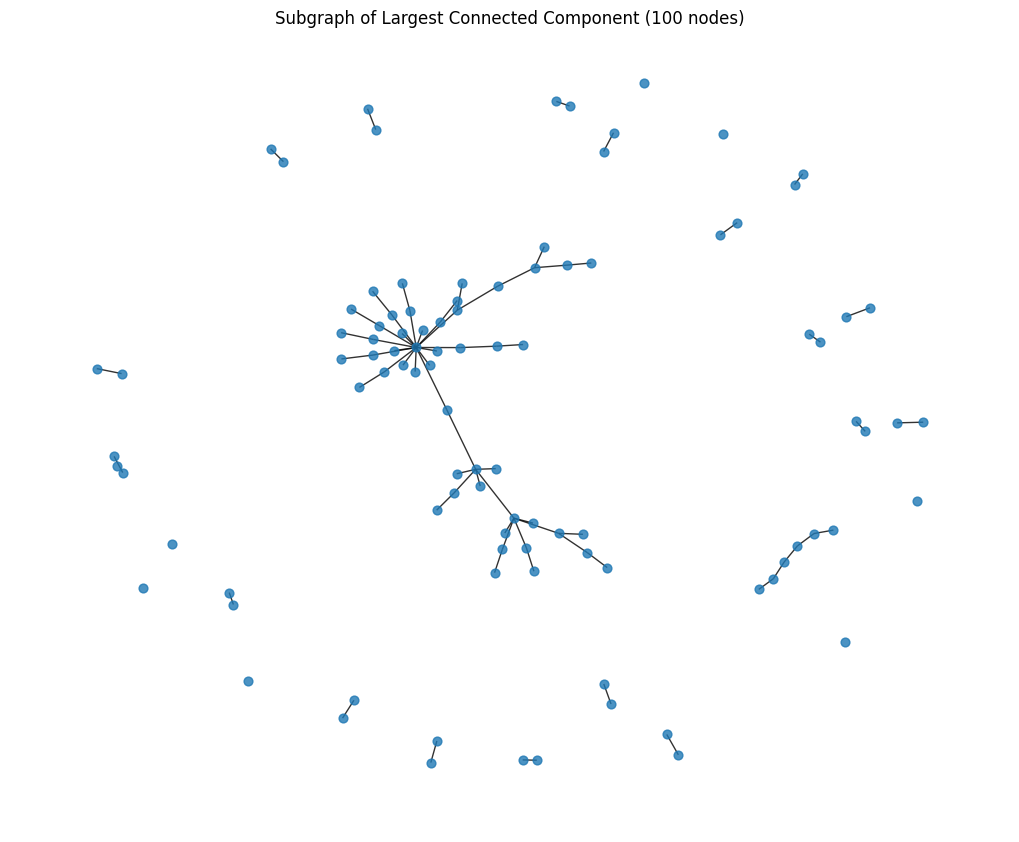

In [ ]:
# 图的连通性检查：
# 1.图是否连通（connected）
# 2.连通子图（connected components）数量
# 3.最大连通子图的节点数量（giant component）
# 转换为无向图进行连通性分析

G_nx_all = to_networkx(elliptic_dataset, to_undirected=True)

# 是否为单一连通图（全图连通）
is_connected = nx.is_connected(G_nx_all)
print(f"Is the full graph connected? {'Yes' if is_connected else 'No'}")

# 连通子图数量（即弱连通分量）
connected_components = list(nx.connected_components(G_nx_all))
print(f"Number of connected components: {len(connected_components)}")

# 最大连通子图大小
largest_cc = max(connected_components, key=len)
print(f"Largest connected component size: {len(largest_cc)}")

# 可视化最大连通子图（取前100节点）
G_lcc = G_nx_all.subgraph(list(largest_cc)[:100])
plt.figure(figsize=(10, 8))
pos = nx.spring_layout(G_lcc, seed=123)
nx.draw(G_lcc, pos, node_size=40, alpha=0.8)
plt.title("Subgraph of Largest Connected Component (100 nodes)")
plt.show()

In [ ]:
# ====================== 超参数与划分 ======================
seed = 0
learning_rate = 0.005
weight_decay = 1e-5
input_dim = 165
output_dim = 1
hidden_size = 150
num_epochs = 400
checkpoints_dir = './result/models/elliptic_tgnn'
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [ ]:
# 所有节点都是有标签样本，划分训练/验证/测试集
all_idx = np.arange(len(labels))
y_all = labels[all_idx]

# 按70:15:15的比例划分训练集、验证集、测试集
train_idx, temp_idx = train_test_split(all_idx, test_size=0.3, random_state=seed, stratify=y_all)
val_idx, test_idx = train_test_split(temp_idx, test_size=0.5, random_state=seed, stratify=labels[temp_idx])

In [ ]:
def get_split_stats(split_idx, edge_index, labels):
    node_mask = np.zeros(len(labels), dtype=bool)
    node_mask[split_idx] = True
    split_labels = labels[split_idx]

    licit_count = int((split_labels == 0).sum())
    illicit_count = int((split_labels == 1).sum())
    total_nodes = len(split_idx)

    # 提取边的子集：两端都在该子集中的边
    mask_edges = node_mask[edge_index[0]] & node_mask[edge_index[1]]
    edge_count = int(mask_edges.sum())

    illicit_ratio = illicit_count / total_nodes * 100

    return licit_count, illicit_count, total_nodes, edge_count, illicit_ratio

# 分别统计三部分
train_stats = get_split_stats(train_idx, edge_index, labels)
val_stats = get_split_stats(val_idx, edge_index, labels)
test_stats = get_split_stats(test_idx, edge_index, labels)

# 统计总数据
total_stats = get_split_stats(np.arange(len(labels)), edge_index, labels)

# 打印表格
from tabulate import tabulate

table = [
    ["Training", *train_stats],
    ["Validation", *val_stats],
    ["Test", *test_stats],
    ["Total", *total_stats]
]

headers = ["Dataset Split", "Licit Nodes", "Illicit Nodes", "Total Nodes", "Total Edges", "Illicit Ratio (%)"]
print(tabulate(table, headers=headers, tablefmt="github", floatfmt=".1f"))

| Dataset Split   |   Licit Nodes |   Illicit Nodes |   Total Nodes |   Total Edges |   Illicit Ratio (%) |
|-----------------|---------------|-----------------|---------------|---------------|---------------------|
| Training        |         29413 |            3181 |         32594 |         18336 |                 9.8 |
| Validation      |          6303 |             682 |          6985 |           817 |                 9.8 |
| Test            |          6303 |             682 |          6985 |           731 |                 9.8 |
| Total           |         42019 |            4545 |         46564 |         36624 |                 9.8 |


In [ ]:
elliptic_dataset.train_idx = torch.tensor(train_idx, dtype=torch.long)
elliptic_dataset.val_idx = torch.tensor(val_idx, dtype=torch.long)
elliptic_dataset.test_idx = torch.tensor(test_idx, dtype=torch.long)

In [ ]:
# ====================== 模型定义 ======================
class TGNN(torch.nn.Module):
    def __init__(self, dim_in, dim_h, dim_out, K=3):
        super().__init__()
        self.norm1 = torch.nn.BatchNorm1d(dim_in)
        self.gat1 = torch_geometric.nn.conv.TAGConv(dim_in, dim_h, K)
        self.norm2 = torch.nn.BatchNorm1d(dim_h)
        self.gat2 = torch_geometric.nn.conv.TAGConv(dim_h, dim_out, K)

    def forward(self, x, edge_index):
        h = self.norm1(x)
        h = self.gat1(h, edge_index)
        h = self.norm2(h)
        h = F.leaky_relu(h)
        out = self.gat2(h, edge_index)
        return out

def accuracy(y_pred, y_test, prediction_threshold=0.5):
    y_pred_label = (torch.sigmoid(y_pred) > prediction_threshold).float()
    correct_results_sum = (y_pred_label == y_test).sum().float()
    acc = correct_results_sum / y_test.shape[0]
    return acc

def train(model, data, criterion, optimizer, *args):
    num_epochs = args[0]
    checkpoint_dir = args[1]
    model_filename = args[2]

    if not os.path.exists(checkpoint_dir):
        os.makedirs(checkpoint_dir)

    best_loss = float('inf')
    model.train()

    for epoch in range(num_epochs):
        optimizer.zero_grad()
        pred = model(data.x, data.edge_index)
        loss = criterion(pred[data.train_idx], data.y[data.train_idx].unsqueeze(1))
        acc = accuracy(pred[data.train_idx], data.y[data.train_idx].unsqueeze(1))

        loss.backward()
        optimizer.step()

        val_loss = criterion(pred[data.val_idx], data.y[data.val_idx].unsqueeze(1))
        val_acc = accuracy(pred[data.val_idx], data.y[data.val_idx].unsqueeze(1))

        if epoch % 10 == 0:
            print(f'Epoch {epoch:>3} | Train Loss: {loss:.3f} | Train Acc: '
                  f'{acc*100:>6.2f}% | Val Loss: {val_loss:.4f} | '
                  f'Val Acc: {val_acc*100:.2f}%')
            if val_loss < best_loss:
                best_loss = val_loss
                print('Saving best model state')
                checkpoint = {'state_dict': model.state_dict()}
                torch.save(checkpoint, os.path.join(checkpoint_dir, model_filename))

    return model

def test(model, data):
    model.eval()
    preds = model(data.x, data.edge_index)
    preds = ((torch.sigmoid(preds) > 0.5).float() * 1).squeeze(1)
    return preds

In [ ]:
# ====================== 模型训练与评估 ======================
torch.manual_seed(seed)

model = TGNN(input_dim, hidden_size, output_dim, K=3).to(device)
data_train = elliptic_dataset.to(device)

optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate, weight_decay=weight_decay)
criterion = torch.nn.BCEWithLogitsLoss()

#train(model, data_train, criterion, optimizer, num_epochs, checkpoints_dir, 'tgnn_best_model.pth.tar')

In [ ]:
# model.load_state_dict(torch.load(os.path.join(checkpoints_dir, 'tgnn_best_model.pth.tar'))['state_dict'])
model.load_state_dict(torch.load(os.path.join('./result/models/elliptic_tgnn_ablation/tgnn_best_model_K3.pth.tar'))['state_dict'])
y_test_preds = test(model, data_train)

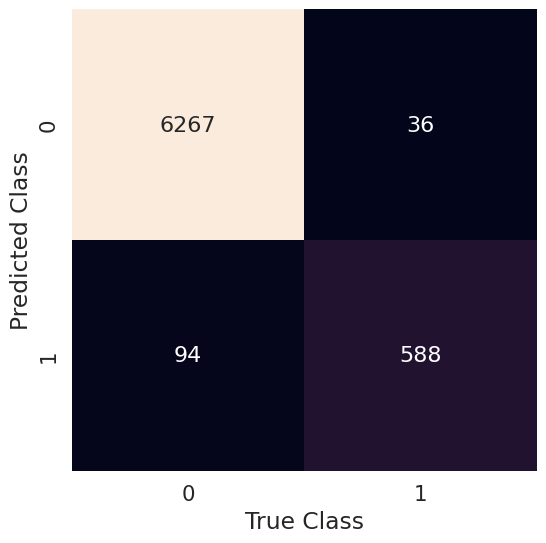

              precision    recall  f1-score   support

       licit       0.99      0.99      0.99      6303
     illicit       0.94      0.86      0.90       682

    accuracy                           0.98      6985
   macro avg       0.96      0.93      0.95      6985
weighted avg       0.98      0.98      0.98      6985



In [ ]:
# ====================== 混淆矩阵与评估 ======================
conf_mat = confusion_matrix(data_train.y[data_train.test_idx].cpu().numpy(),
                            y_test_preds[data_train.test_idx].cpu())

plt.figure(figsize=(6,6))
sns.set(font_scale=1.4)
sns.heatmap(conf_mat, annot=True, fmt=".0f", annot_kws={"size": 16}, cbar=False)
plt.xlabel('True Class'); plt.ylabel('Predicted Class');
# plt.title('Confusion Matrix')
plt.savefig("./result/ConfusionMatrix.png", dpi=300, bbox_inches='tight')
plt.show()

print(classification_report(data_train.y[data_train.test_idx].cpu().numpy(),
                            y_test_preds[data_train.test_idx].cpu(),
                            target_names=['licit', 'illicit']))

In [ ]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, matthews_corrcoef

model.eval()

with torch.no_grad():
    output = model(data_train.x, data_train.edge_index)
    prob = torch.sigmoid(output[data_train.test_idx]).squeeze().cpu().numpy()
    y_pred = (prob > 0.5).astype(int)
    y_true = data_train.y[data_train.test_idx].cpu().numpy().astype(int)

# average='binary'
acc = accuracy_score(y_true, y_pred)
prec = precision_score(y_true, y_pred)
rec = recall_score(y_true, y_pred)
f1 = f1_score(y_true, y_pred)
mcc = matthews_corrcoef(y_true, y_pred)

print(f"\nTest Metrics:")
print(f"Accuracy:  {acc:.4f}")
print(f"Precision: {prec:.4f}")
print(f"Recall:    {rec:.4f}")
print(f"F1-score:  {f1:.4f}")
print(f"MCC:       {mcc:.4f}")


Test Metrics:
Accuracy:  0.9814
Precision: 0.9423
Recall:    0.8622
F1-score:  0.9005
MCC:       0.8913


In [ ]:
from sklearn.manifold import TSNE
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
from matplotlib.patches import Patch
import seaborn as sns

def tsne_visualize(features, labels, title, filename, perplexity=30):
    """
    使用t-SNE进行二维可视化，并绘制分类图
    """
    # 标准化特征输入（有助于t-SNE收敛）
    features = StandardScaler().fit_transform(features)

    # t-SNE降维
    z = TSNE(n_components=2, perplexity=perplexity, init='random', random_state=42).fit_transform(features)

    # 可视化配置
    plt.figure(figsize=(8, 8))
    # palette = sns.color_palette("Set2", 2)
    sns.set_style("whitegrid")

    palette = ["#458B00", "#EE0000"]
    legend_labels = ["Licit (0)", "Illicit (1)"]
    handles = [Patch(color=palette[i], label=legend_labels[i]) for i in range(2)]


    scatter = sns.scatterplot(x=z[:, 0], y=z[:, 1], hue=labels, palette=palette, s=40, alpha=0.8)
    plt.title(title, fontsize=16)
    plt.xlabel("t-SNE Dim 1", fontsize=16)
    plt.ylabel("t-SNE Dim 2", fontsize=16)
    plt.xticks([])
    plt.yticks([])
    plt.legend(handles=handles, title="Class", loc='best', fontsize=14)
    plt.tight_layout()
    plt.savefig(filename, dpi=300)
    plt.show()


# -------- 加载模型并计算中间层特征表示 --------
model.eval()

# 原始节点特征（验证集）
x_train = data_train.x[data_train.train_idx].cpu().numpy()
y_train = data_train.y[data_train.train_idx].cpu().numpy()

# 模型第一层表征：
with torch.no_grad():
    h1 = model.norm1(data_train.x)
    h1 = model.gat1(h1, data_train.edge_index)
    h1_train = h1[data_train.train_idx].cpu().numpy()

# 模型第二层表征：
with torch.no_grad():
    h1 = model.norm1(data_train.x)
    h1 = model.gat1(h1, data_train.edge_index)
    h1 = model.norm2(h1)
    h1 = F.leaky_relu(h1)
    h2 = model.gat2(h1, data_train.edge_index)
    h2_train = h2[data_train.train_idx].cpu().numpy()


# -------- 调用函数进行可视化 --------
tsne_visualize(x_train, y_train, title="", filename="./result/train_tsne_raw_features.png")
tsne_visualize(h1_train, y_train, title="", filename="./result/train_tsne_tgnn_first_layer_features.png")
tsne_visualize(h2_train, y_train, title="", filename="./result/train_tsne_tgnn_second_layer_features.png")

Output hidden; open in https://colab.research.google.com to view.

In [ ]:
from collections import Counter

# 1. 统计所有节点的度数（连通边的数量）
all_degrees = Counter(edge_index[0].tolist() + edge_index[1].tolist())

# 2. 获取训练集节点索引
train_nodes = elliptic_dataset.train_idx.tolist()

# 3. 获取训练集中 class == 1 的节点（非法交易）
train_class_1_nodes = [node for node in train_nodes if labels[node] == 1]

# 4. 在这些节点中，筛选度数 > 4 的
train_high_degree_class_1_nodes = [node for node in train_class_1_nodes if all_degrees[node] > 4]

print(f"训练集中 class=1 且连通数>4 的节点数: {len(train_high_degree_class_1_nodes)}")
print(f"示例节点索引: {train_high_degree_class_1_nodes[:10]}")


训练集中 class=1 且连通数>4 的节点数: 22
示例节点索引: [23607, 29390, 17494, 31401, 44965, 18000, 35560, 32943, 29407, 31473]


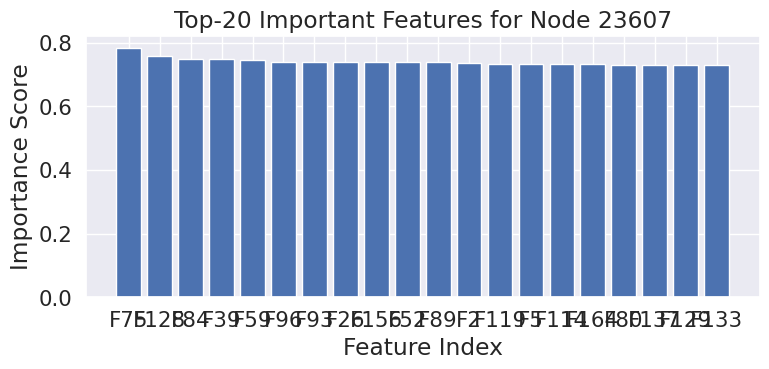

In [ ]:
# ---------------------------
# 4. 使用 GNNExplainer 获取结构和特征重要性
# ---------------------------
from torch_geometric.explain import Explainer, GNNExplainer
from torch_geometric.explain.config import ModelConfig, ExplainerConfig

model.eval()

# 构建 Explainer
explainer = Explainer(
    model=model,
    algorithm=GNNExplainer(epochs=100),
    explanation_type='model',
    model_config=ModelConfig(
        mode='multiclass_classification',
        task_level='node',
        return_type='log_probs'
    ),
    node_mask_type='attributes',
    edge_mask_type='object'
)

# 选择测试集某一个节点解释
node_idx = 23607
explanation = explainer(x=data_train.x, edge_index=data_train.edge_index, index=node_idx)

import matplotlib.pyplot as plt
import numpy as np

feature_importance = explanation.node_mask[node_idx].detach().cpu().numpy()

# 取 Top-10 特征索引和权重
topk = 20
topk_idx = np.argsort(feature_importance)[-topk:][::-1]  # 从大到小排序
topk_values = feature_importance[topk_idx]

# 可视化
plt.figure(figsize=(8, 4))
plt.bar(range(topk), topk_values, tick_label=[f"F{idx}" for idx in topk_idx])
plt.xlabel("Feature Index")
plt.ylabel("Importance Score")
plt.title(f"Top-{topk} Important Features for Node {node_idx}")
plt.tight_layout()
plt.savefig('top10_feature_importance_node23607.pdf')
plt.show()

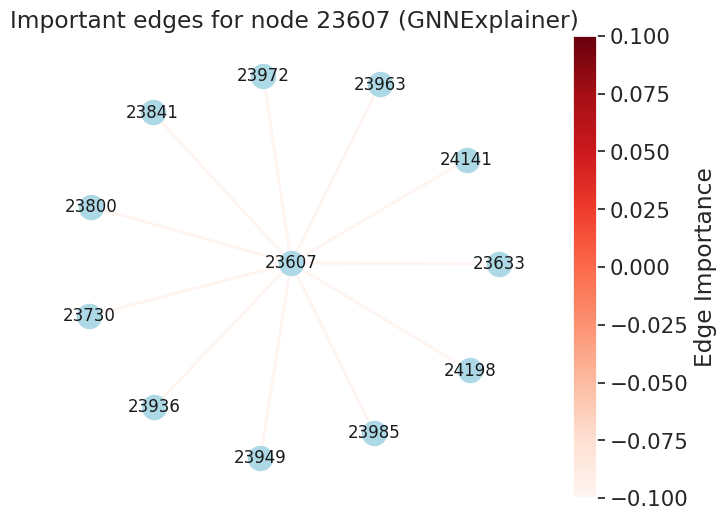

In [ ]:
# 结构重要性分析（Structural Importance Analysis）：找出哪些边（邻居关系）最影响该节点的分类结果
"""
核心内容：评估图中每条边（或者节点间连接关系）对模型预测结果的重要程度。
输出形式：通常是一个与边数相同的权重向量（edge_mask），每个值表示对应边对预测的贡献或重要度，数值越大表示该边越关键。
目的：定量地告诉你“哪些连接/邻居关系”最影响模型做出的预测。
举例：节点10的预测结果中，边(10,15)的权重为0.8，边(10,20)的权重为0.1，说明边(10,15)比边(10,20)对结果影响更大。
"""
from torch_geometric.utils import k_hop_subgraph, to_networkx
import matplotlib.pyplot as plt
import networkx as nx
import matplotlib as mpl

node_idx = 23607  # 要解释的节点
num_hops = 3   # 邻接层数

# 提取子图节点/边索引
subset, edge_index_sub, mapping, hard_edge_mask = k_hop_subgraph(
    node_idx, num_hops=num_hops, edge_index=data_train.edge_index, relabel_nodes=True)

# 从全图中提取子图 edge 掩码（注意要找 edge 对应的掩码）
full_edge_mask = explanation.edge_mask.detach().cpu().numpy()

# 构建 NetworkX 图
G = to_networkx(data_train, to_undirected=True)

# 获取子图
G_sub = G.subgraph(subset.tolist())

# 生成与子图中每条边对应的掩码值（通过原始 edge_index 查找）
edge_mask_dict = {}
edge_tuples = data_train.edge_index.t().tolist()  # 所有边 (source, target)

for i, (src, dst) in enumerate(edge_tuples):
    if src in subset and dst in subset:
        edge_mask_dict[(src, dst)] = full_edge_mask[i]
        edge_mask_dict[(dst, src)] = full_edge_mask[i]  # 因为是无向图

# 子图中的每条边的掩码值
edge_colors = []
for src, dst in G_sub.edges():
    val = edge_mask_dict.get((src, dst), 0.0)
    edge_colors.append(val)

# 画图
plt.figure(figsize=(8, 6))
ax = plt.gca()
nx.draw_networkx(
    G_sub,
    with_labels=True,
    node_color='lightblue',
    edge_color=edge_colors,
    edge_cmap=plt.cm.Reds,
    width=2
)
# 创建带有数据范围的 ScalarMappable
norm = mpl.colors.Normalize(vmin=min(edge_colors), vmax=max(edge_colors))
sm = mpl.cm.ScalarMappable(cmap=plt.cm.Reds, norm=norm)
sm.set_array([])  # 这里必须调用 set_array，参数可为空

# 添加 colorbar，绑定到当前坐标轴ax
plt.colorbar(sm, ax=ax, label='Edge Importance')

plt.title(f"Important edges for node {node_idx} (GNNExplainer)")
plt.axis('off')
plt.show()

In [ ]:
import shap
import numpy as np
import torch.nn.functional as F

# ---------------------------
# 5. 使用 SHAP 分析节点特征重要性
# ---------------------------

def model_predict(x_numpy_batch):
    model.eval()
    x_clone = data_train.x.clone().to(device)
    outputs = []
    with torch.no_grad():
        for i in range(x_numpy_batch.shape[0]):
            x_clone[node_idx] = torch.tensor(x_numpy_batch[i], dtype=torch.float32, device=device)
            out = model(x_clone, data_train.edge_index)
            prob = torch.sigmoid(out)[node_idx]
            outputs.append(prob.cpu().numpy())
    return np.array(outputs)

# 多节点
num_samples = 1
all_indices = np.arange(data_train.x.shape[0])
sample_indices = np.random.choice(all_indices, size=num_samples, replace=False)
node_feat_batch = data_train.x[sample_indices].cpu().numpy()

explainer = shap.Explainer(model_predict, masker=shap.maskers.Independent(data_train.x.cpu().numpy()))


shap_values = explainer(node_feat_batch)
shap.plots.bar(shap_values)
# feature_names=[f'feat_{i}' for i in range(node_feat_batch.shape[1])]

# shap.summary_plot(shap_values.values, features=node_feat_batch, feature_names=feature_names, plot_type="bar", show=True)
# plt.savefig("./result/shap_summary_plot.png", dpi=300, bbox_inches='tight')
# plt.close()

PermutationExplainer explainer:  80%|████████  | 8/10 [48:33<13:31, 405.56s/it]

/tmp/ipython-input-20-3935337395.py:1: FutureWarning: The NumPy global RNG was seeded by calling `np.random.seed`. In a future version this function will no longer use the global RNG. Pass `rng` explicitly to opt-in to the new behaviour and silence this warning.
  shap.summary_plot(shap_values.values, features=node_feat_batch, feature_names=feature_names, show=True)


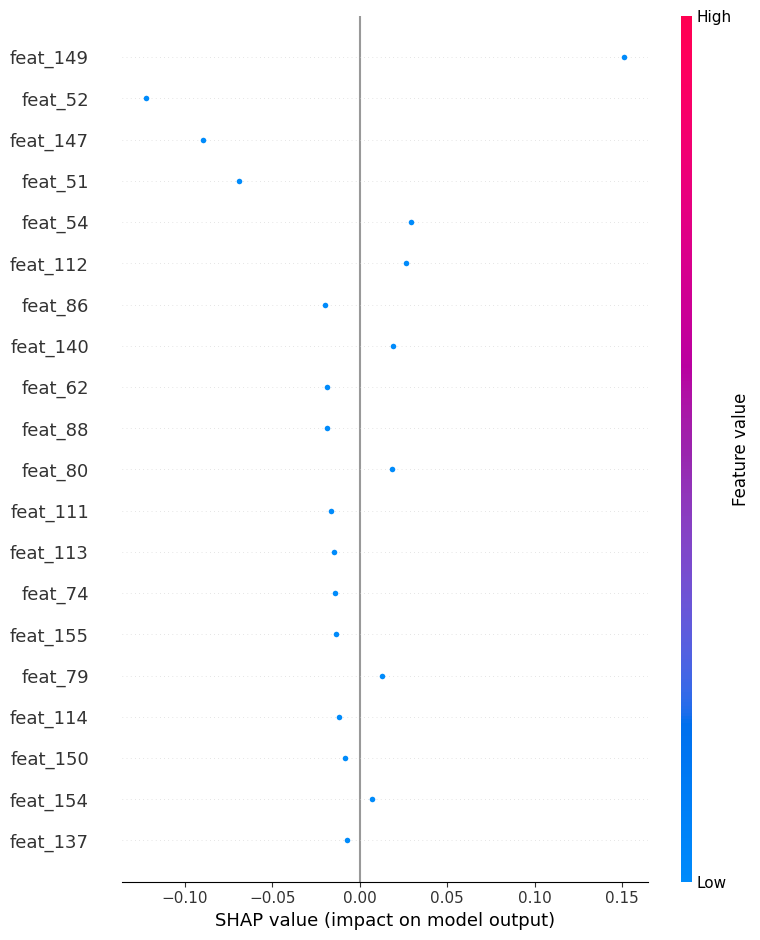

In [ ]:
shap.summary_plot(shap_values.values, features=node_feat_batch, feature_names=feature_names, show=True)
plt.savefig("./result/shap_summary_plot.png", dpi=300, bbox_inches='tight')
plt.close()

# shap.dependence_plot("Time", shap_values.values, features=node_feat_batch, feature_names=feature_names, show=True)
# plt.savefig("./result/shap_summary_plot.png", dpi=300, bbox_inches='tight')
# plt.close()

PermutationExplainer explainer: 2it [04:01, 241.99s/it]              


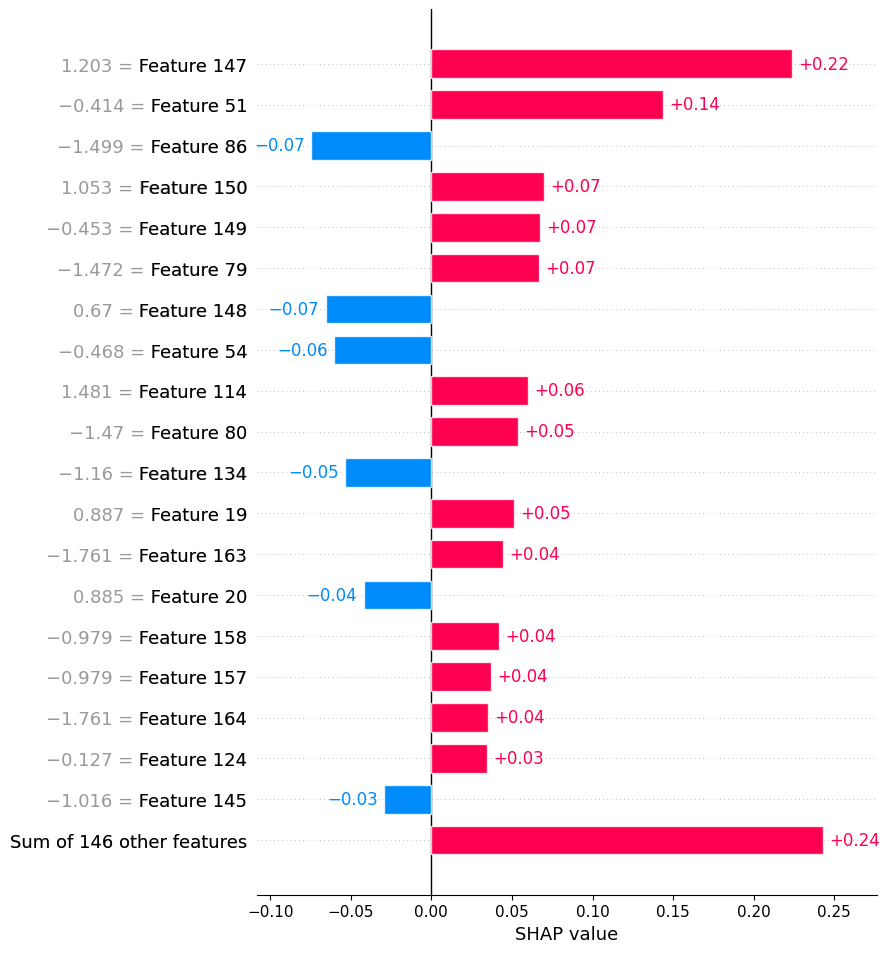

In [ ]:
import shap
# 单一节点的特征重要性解释分析（bar plot）
node_idx = 28207  # 固定节点ID

def model_predict(x_numpy_batch):
    model.eval()
    x_clone = data_train.x.clone().to(device)
    outputs = []
    with torch.no_grad():
        for i in range(x_numpy_batch.shape[0]):
            x_clone[node_idx] = torch.tensor(x_numpy_batch[i], dtype=torch.float32, device=device)
            out = model(x_clone, data_train.edge_index)
            prob = torch.sigmoid(out)[node_idx]
            outputs.append(prob.cpu().numpy())
    return np.array(outputs)

# 单节点
node_feat = data_train.x[node_idx].cpu().numpy().reshape(1, -1)
explainer = shap.Explainer(model_predict, masker=shap.maskers.Independent(data_train.x.cpu().numpy()))
shap_values = explainer(node_feat)

shap.plots.bar(shap_values[0], max_display=20)
plt.tight_layout()
plt.savefig("./result/shap_node28207.png", dpi=300)
plt.close()

In [ ]:
# Force Plot 是 SHAP 经典图，用一个“拉锯图”来展示模型是如何在每个特征推动下，从基准值（expected output）走向最终预测值；适合论文中展示某一“illicit 交易”的详细解释路径；
shap.initjs()
shap.plots.force(shap_values[0])
# shap.save_html("./result/force_plot_node28207.html", shap.plots.force(shap_values[0]))

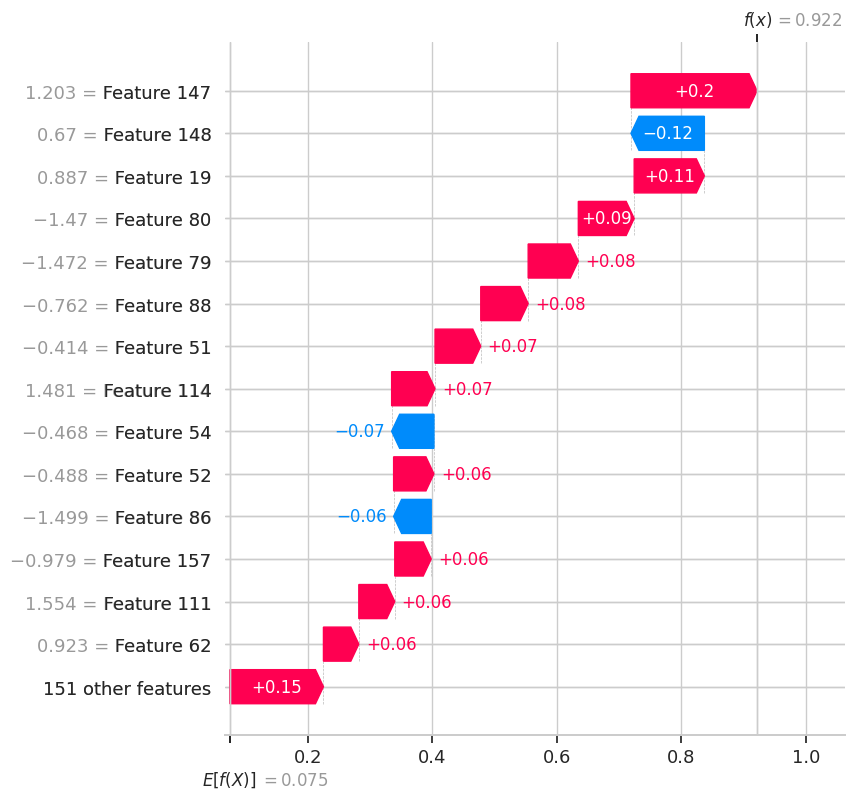

In [ ]:
# Waterfall Plot（局部决策贡献瀑布图），是Force Plot的静态版本，Y 轴是特征，X 轴是其“推高 or 拉低”模型输出的影响
# 颜色区分推动方向（蓝色 = negative、红色 = positive），特别适合解释某个重要交易节点
shap.plots.waterfall(shap_values[0], max_display=15)
plt.tight_layout()
plt.savefig("./result/shap_waterfall.png", dpi=300)
plt.close()

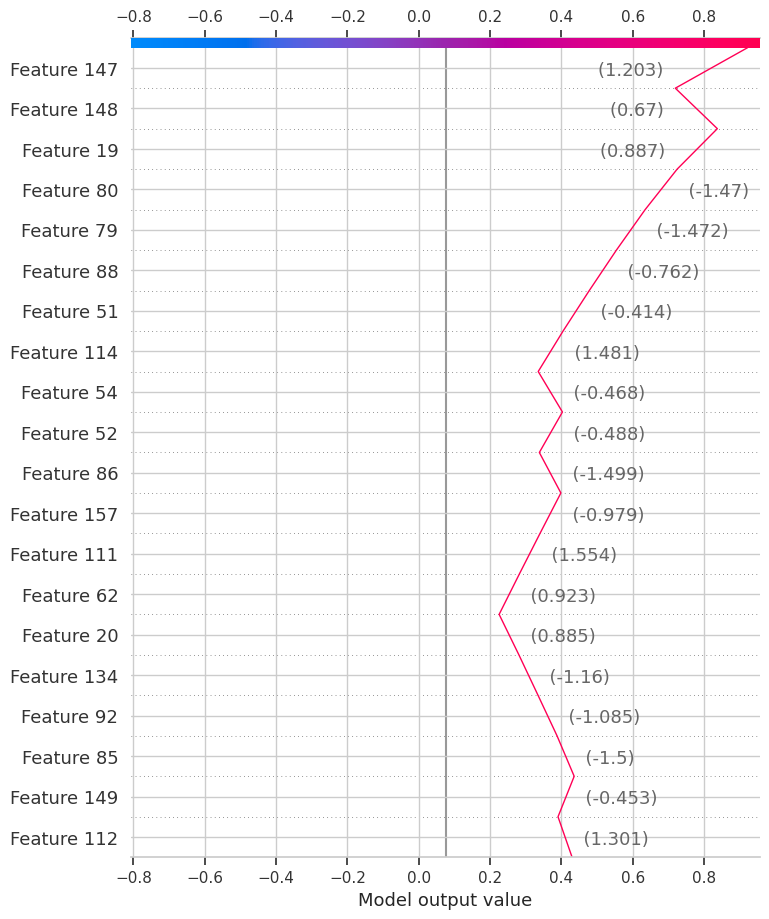

In [ ]:
# 绘制决策路径图（Decision Plot）
# 特征名称（用于图上标注）
feature_names = [f"Feature {i}" for i in range(data_train.x.shape[1])]
shap.decision_plot(
    base_value=shap_values.base_values[0],
    shap_values=shap_values.values[0],
    features=node_feat[0],
    feature_names=feature_names,
    show=False
)
# plt.title(f"SHAP Decision Plot for Node {node_idx}")
plt.tight_layout()
plt.savefig(f"shap_decision_plot_node{node_idx}.pdf")
plt.savefig("./result/shap_decision_plot.png", dpi=300)
plt.show()